# Selekcja Zmiennych

1. [Embedded methods](#Embedded-methods)
    - [Feature Importance w drzewach decyzyjnych](#Feature-Importance-w-drzewach-decyzyjnych)
2. [Filter-based methods](#Filter-based-methods)
    - [Univariate Feature Selection + f-Anova](#Univariate-Feature-Selection-+-f-Anova)
    - [Korelacje](#Korelacje)
3. [Wrapper-based methods](#Wrapper-based-methods)
    - [Recursive Feature Elimination](#Recursive-Feature-Elimination)
    - [Forward Feature Selection](#Forward-Feature-Selection)

## Przygotowanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

In [2]:
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
y = cancer['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<b>Atrybuty</b>

- radius - promień (średnia odległości od środka do punktów na obwodzie)
- texture - tekstura (odchylenie standardowe wartości skali szarości)
- perimeter - obwód
- area - powierzchnia
- smoothness - gładkość (lokalna zmienność długości promieni)
- compactness - zwartość (obwód^2 / powierzchnia - 1,0)
- concavity - wklęsłość
- concave points - punkty wklęsłe (liczba wklęsłych części konturu)
- symmetry - symetria
- fractal dimension - wymiar fraktalny ("przybliżenie linii brzegowej" - 1)

# Feature Selection

## Embedded methods

<div class="alert alert-block alert-success">
📍<b>Embedded (intrinsic) methods</b><br>
    Embedded (intrinsic) methods - metody osadzone w modelach, np. drzewa decyzyjne, lasy losowe, Lasso.
</div>

### Feature Importance w drzewach decyzyjnych

<div class="alert alert-block alert-info">
📝 <b>Zadanie 1.1</b><br>
    Przygotujmy model drzewa decyzyjnego z parametrami <code>max_depth=10</code> i <code>min_samples_split=5</code>. <br>
    Następnie, korzystając z atrybutu <code>feature_importances_</code>, wskażmy istotności zmiennych.
</div>

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
dt.fit(df, y)

DecisionTreeClassifier(max_depth=10, min_samples_split=5)

In [6]:
feature_importances = dict(zip(dt.feature_names_in_, dt.feature_importances_))
feature_importances = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances

worst radius               0.703527
worst concave points       0.115289
worst texture              0.053120
mean texture               0.042969
compactness error          0.032205
worst smoothness           0.014569
worst area                 0.011212
mean concavity             0.008871
symmetry error             0.007399
mean compactness           0.005898
area error                 0.002069
worst concavity            0.001857
smoothness error           0.001015
worst compactness          0.000000
worst perimeter            0.000000
worst symmetry             0.000000
fractal dimension error    0.000000
mean radius                0.000000
concave points error       0.000000
concavity error            0.000000
perimeter error            0.000000
texture error              0.000000
radius error               0.000000
mean fractal dimension     0.000000
mean symmetry              0.000000
mean concave points        0.000000
mean smoothness            0.000000
mean area                  0

<div class="alert alert-block alert-info">
📝 <b>Zadanie 1.2</b><br>
    Zwizualizujmy istotności zmiennych na wykresie słupkowym.
</div>

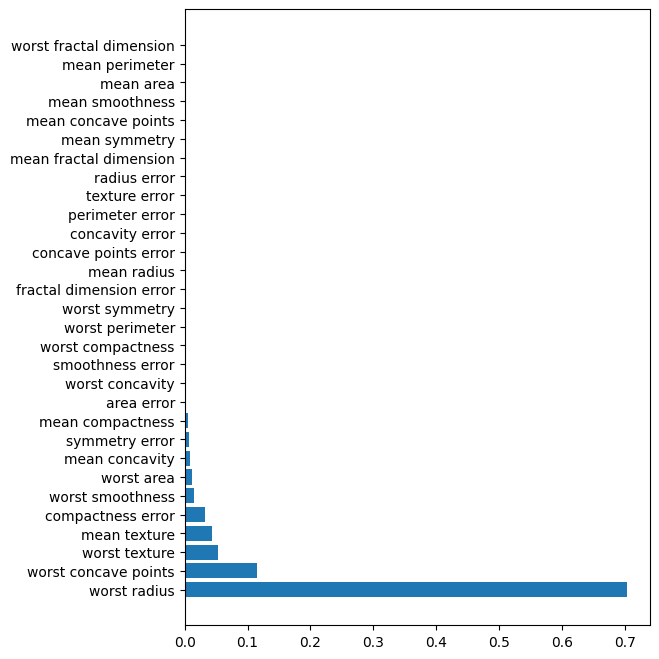

In [7]:
plt.figure(figsize=(6, 8))
plt.barh(feature_importances.index, feature_importances.values)
plt.show()

## Filter-based methods

<div class="alert alert-block alert-success">
📍<b>Filter methods</b><br>
    Filter methods wyróżniają się tym, że mogą być zastosowane przed rozpoczęciem procesu uczenia naszego modelu, przez co stanowią zazwyczaj pierwszy krok w selekcji cech w pipelinach.<br>
Są dobre do eliminacji cech nieistotnych wobec zmiennej objaśnianej, powielanych informacji, wartości zduplikowanych i skorelowanych.
</div>

### Korelacje

Istotne cechy są silnie skorelowane ze <b>zmienną objaśnianą</b>.

<div class="alert alert-block alert-info">
📝 <b>Zadanie 3.1</b><br>
    Sprawdźmy bezwzględne wartości korelacji etykiety ze wszystkimi cechami.<br>
    Przedstawmy te warości na wykresie (np. słupkowym).<br>
    Znajdźmy cechy, które najsilniej korelują z etykietą.
</div>

In [12]:
df.corr()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


In [8]:
corr = df.assign(y=y).corr()


In [9]:
abs_corr = abs(corr).sort_values('y', ascending=False)

In [10]:
abs_corr['y']

y                          1.000000
worst concave points       0.793566
worst perimeter            0.782914
mean concave points        0.776614
worst radius               0.776454
mean perimeter             0.742636
worst area                 0.733825
mean radius                0.730029
mean area                  0.708984
mean concavity             0.696360
worst concavity            0.659610
mean compactness           0.596534
worst compactness          0.590998
radius error               0.567134
perimeter error            0.556141
area error                 0.548236
worst texture              0.456903
worst smoothness           0.421465
worst symmetry             0.416294
mean texture               0.415185
concave points error       0.408042
mean smoothness            0.358560
mean symmetry              0.330499
worst fractal dimension    0.323872
compactness error          0.292999
concavity error            0.253730
fractal dimension error    0.077972
smoothness error           0

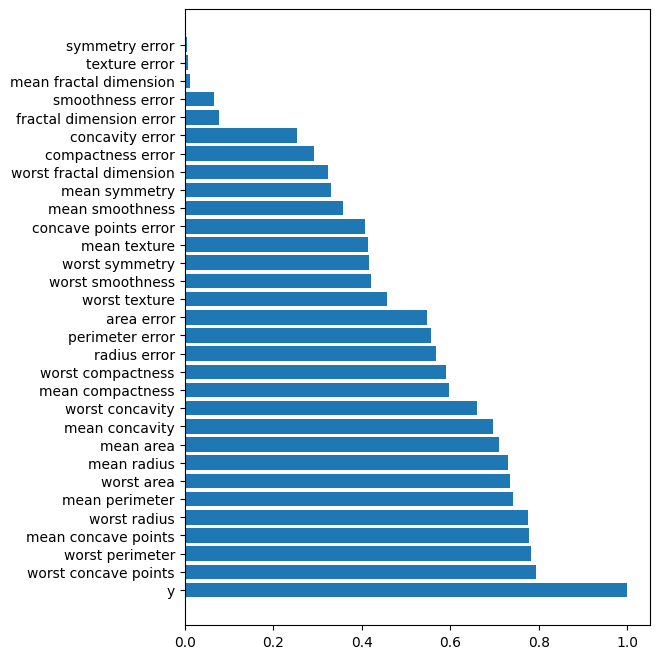

In [11]:
plt.figure(figsize=(6, 8))
plt.barh(abs_corr.index, abs_corr['y'])
plt.show()

## Wrapper-based methods
<div class="alert alert-block alert-success">
📍<b>Wrapper-based methods - Metody opakowane</b><br>
</div>


### Recursive Feature Elimination

<div class="alert alert-block alert-success">
📍<b>Rekurencyjna Eliminacja Zmiennych - Recursive Feature Elimination</b><br>
    Celem Rekurencyjnej Eliminacji Zmiennych (RFE) jest selekcja rekurencyjnie uwględniająca coraz mniejsze zestawy atrybutów z wykorzystaniem estymatora.<br>

Schemat działania:
<ol>
<li>Obliczenie istotności zmiennej w modelu uwzględniającym pełny zestaw cech.</li>
<li>Usunięcie najmniej istotnych cech.</li>
    W funkcji RFE z scikit-learn, argument <code>step</code> określa liczbę cech, które usuwamy w każdym kroku.
<li>Zbudowanie modelu bez usuniętych cech i obliczenie nowych istotności zmiennych.
<li>Powtarzamy kroki 2.-3., dopóki kryterium stopu nie zostanie osiągnięte.</li>
Kryterium stopu to np. osiągnięcie minimalnej liczby cech w modelu określonej przez użytkownika (W RFE z scikit-learn jest to argument <code>n_features_to_select</code>).
</ol><br>
Zmodyfikowana funkcja RFECV dodatkowo wykorzystuje walidację krzyżową w celu znalezienia optymalnej liczby cech.
</div>


<div class="alert alert-block alert-info">
📝 <b>Zadanie 4</b><br>
    Przygotujmy estymator drzewa decyzyjnego z parametrami <code>max_depth=10</code> i <code>min_samples_split=5</code>.<br>
    Za pomocą rekurencyjnej eliminacji zmiennych, wskażmy 5 istotnych zmiennych (<code>n_features_to_select=5</code>).
    W każdym kroku RFE eliminujmy po jednej zmiennej (<code>step=1</code>).
</div>

In [13]:
from sklearn.feature_selection import RFE

k_best = 5
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
selector = RFE(dt, 
               n_features_to_select=k_best, 
               step=1  # number of features to remove at each iteration
               )
selector = selector.fit(df, y)

In [14]:
selector.get_feature_names_out()

array(['mean concave points', 'worst radius', 'worst texture',
       'worst area', 'worst concave points'], dtype=object)

In [15]:
selector.ranking_

array([26, 23, 22, 21, 20, 19, 16,  1, 13, 12,  6, 11, 10,  3,  4, 14, 18,
       17, 15,  9,  1,  1,  8,  1,  2,  5,  7,  1, 24, 25])

<div class="alert alert-block alert-info">
    ❓ <b>Pytanie<br>
    Dlaczego warto eliminować cechy iteracyjnie?</b> <br>
</div>
<br>
